### Import Libraries

In [1]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from pathlib import Path
from mne import channels

### Load data

In [2]:
# Amount of cores to use in multiprocessing
cpus = 8

eeg_data = xr.load_dataset('data/sat1/data22-25.nc')

# Set up montage according to 10-20 system
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']

# Load x and y positions of electrodes
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])


### Prepare data

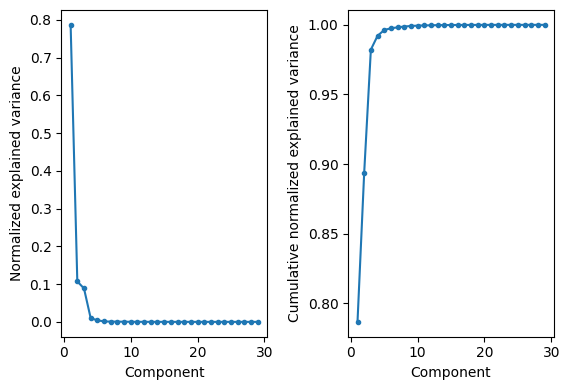

In [3]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize model

In [72]:
# Select only condition for accuracy, not speed
model_all = hmp.models.hsmm(hmp_data, eeg_data, bump_width=50, cpus=cpus,
                                 sfreq=eeg_data.sfreq)

hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'AC')
model_accuracy = hmp.models.hsmm(hmp_accuracy_data, eeg_data, bump_width=50, cpus=cpus,
                                 sfreq=eeg_data.sfreq, estimate_magnitudes=False)

hmp_speed_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'SP')
model_speed = hmp.models.hsmm(hmp_speed_data, eeg_data, bump_width=50, cpus=cpus,
                              sfreq=eeg_data.sfreq, estimate_magnitudes=False)


In [73]:
fit_all = model_all.fit(step=1)

fit_accuracy = model_accuracy.fit(step=1)

fit_speed = model_speed.fit(step=1)

  0%|          | 0/72 [00:00<?, ?it/s]

Transition event 2 found around sample 26 (step 0): Transition event samples = [12. 26.]
Transition event 3 found around sample 40 (step 1): Transition event samples = [12. 24. 40.]
Transition event 4 found around sample 44 (step 3): Transition event samples = [12. 24. 37. 44.]
Estimating 4 bumps model
Parameters estimated for 4 bumps model


  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 2 found around sample 27 (step 0): Transition event samples = [12. 27.]
Transition event 3 found around sample 44 (step 1): Transition event samples = [12. 25. 44.]
Transition event 4 found around sample 67 (step 2): Transition event samples = [12. 25. 44. 67.]
Transition event 5 found around sample 64 (step 4): Transition event samples = [12. 24. 35. 57. 64.]
Estimating 5 bumps model
Parameters estimated for 5 bumps model


  0%|          | 0/53 [00:00<?, ?it/s]

Transition event 2 found around sample 25 (step 8): Transition event samples = [12. 25.]
Transition event 3 found around sample 45 (step 9): Transition event samples = [12. 24. 45.]
Estimating 3 bumps model
Parameters estimated for 3 bumps model


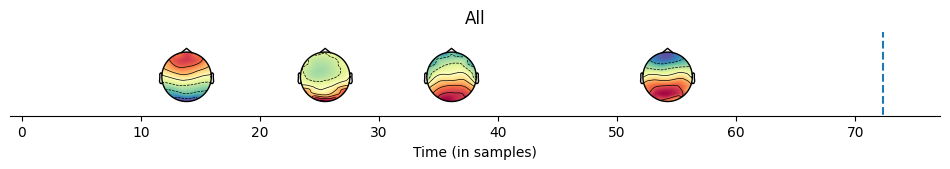

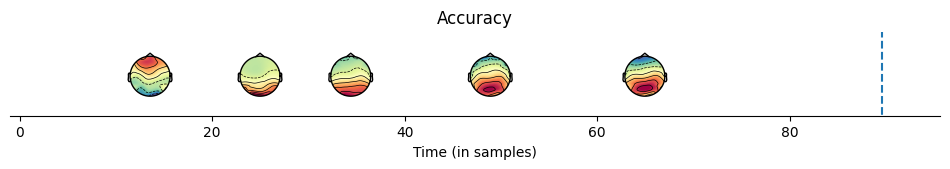

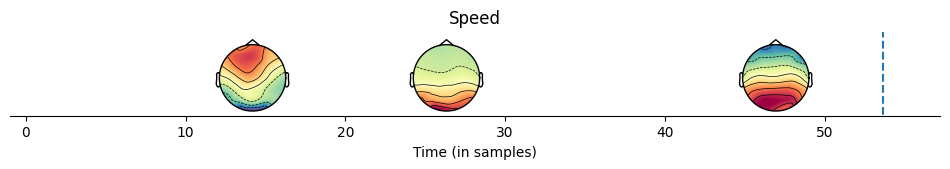

In [74]:
hmp.visu.plot_topo_timecourse(eeg_data, fit_all, positions, model_all, title='All')

hmp.visu.plot_topo_timecourse(eeg_data, fit_accuracy, positions, model_accuracy, title='Accuracy')

hmp.visu.plot_topo_timecourse(eeg_data, fit_speed, positions, model_speed, title='Speed')


In [19]:
fit_accuracy

<xarray.Dataset>
Dimensions:              (stage: 6, parameter: 2, bump: 5, component: 4,
                          trial_x_participant: 374, samples: 210)
Coordinates:
  * bump                 (bump) int32 0 1 2 3 4
  * samples              (samples) int32 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0022' '0022' ... '0025'
  * trials               (trial_x_participant) int64 0 3 4 5 ... 174 175 179 181
Dimensions without coordinates: stage, parameter, component
Data variables:
    likelihoods          float64 1.089e+03
    parameters           (stage, parameter) float64 2.0 5.528 2.0 ... 2.0 13.6
    magnitudes           (bump, component) float64 -1.606 -0.03541 ... -1.147
    eventprobs           (trial_x_participant, samples, bump) float64 0.0 ......

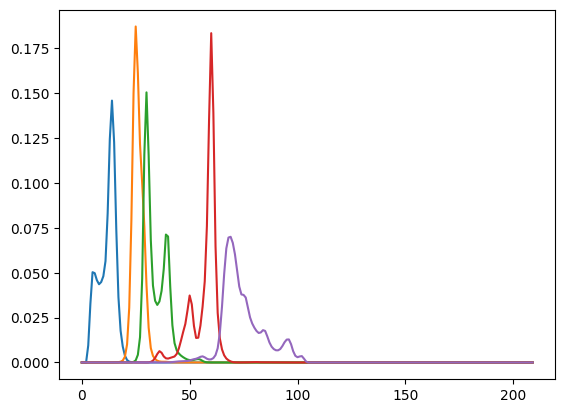

<xarray.DataArray 'eventprobs' (samples: 210, bump: 5)>
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
Coordinates:
  * bump                 (bump) int32 0 1 2 3 4
  * samples              (samples) int32 0 1 2 3 4 5 ... 204 205 206 207 208 209
    trial_x_participant  object ('0023', 21)
    participant          <U4 '0023'
    trials               int64 21


In [62]:
import matplotlib.pyplot as plt
plt.plot(fit_accuracy.eventprobs[100,:,:])
plt.show()
print(fit_accuracy.eventprobs[100,:,:])

# print(fit_speed.eventprobs[3,:,0].idxmax())
# print(fit_speed.eventprobs[3,:,1].idxmax())
# print(fit_speed.eventprobs[3,:,2].idxmax())

In [71]:
# Wanted to find maximum indices of each trial x epoch x bump
maxes = fit_speed.eventprobs.max(dim=['samples', 'bump'])

<xarray.DataArray 'eventprobs' (trial_x_participant: 348)>
array([0.16335439, 0.22371889, 0.38479025, 0.37012163, 0.21095929,
       0.3893892 , 0.30537582, 0.22335267, 0.28161743, 0.16573711,
       0.35493709, 0.29446335, 0.36478153, 0.31608389, 0.27405819,
       0.30551119, 0.29411397, 0.20232854, 0.26509706, 0.38689649,
       0.30838448, 0.34468386, 0.37405469, 0.4642212 , 0.35573854,
       0.26861993, 0.33936066, 0.25724585, 0.3711087 , 0.35030771,
       0.31066391, 0.25164012, 0.41131994, 0.20861407, 0.34679127,
       0.28371838, 0.23184702, 0.32196759, 0.44051461, 0.23100195,
       0.23036585, 0.3480755 , 0.25749315, 0.28691498, 0.33831863,
       0.25596993, 0.37131498, 0.28183487, 0.37873544, 0.30997321,
       0.32254625, 0.28978561, 0.31325281, 0.32996417, 0.3597454 ,
       0.42744259, 0.16963467, 0.37141571, 0.34619434, 0.2749084 ,
       0.31440021, 0.3632025 , 0.18984907, 0.39935222, 0.21291138,
       0.381393  , 0.21585839, 0.23430742, 0.29196241, 0.25928897,
   